Reading DWAQ Segment Files
--

Example of reading and plotting DWAQ segment files.

This relies on the sample dfm/dwaq run having been executed already,
such that we can load the DWAQ-formatted hydro output.

In [1]:
import stompy.model.delft.waq_scenario as dwaq
from stompy.grid import unstructured_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# If you have a hyd file and the segment file you want
# to load is one of the parameters, it's a bit simpler:
hydro=dwaq.HydroFiles('dfm_dwaq/dwaq_run/com-waqmodel.hyd')

In [3]:
# DFM output temperature and salinity segment files --
# Load salinity via the hydro object:
param_name='temp' # 'temp' or 'salinity'
seg_func=hydro.parameters()[param_name] 

# These can be large, so by default the data is not loaded.
# (though with the memory-mapped IO large files can be loaded
# fairly quickly)
seg_func.load_from_segment_file()

# Now there is a .values attribute:
print("Segment files has %d time steps, and %d segments"%(seg_func.values.shape[0],
                                                          seg_func.values.shape[1]))
print("Times are from %d to %d seconds (starting from model reference time)"%(seg_func.times[0],seg_func.times[-1]))


# There is an evaluate() method, but it's poorly designed.  Just reach in 
# and grab the data to plot:
seg_snapshot=seg_func.values[-1,:] # last timesteps, all segments

# Segments are ordered surface-layer, next layer, ..., bed layer,
# Reshape this to split layer and horizontal cell into separate dimensions:
g=hydro.grid()
seg_3d=seg_snapshot.reshape( [-1,g.Ncells()])
print("Looks like %d layers"%seg_3d.shape[0])
print("Values range from %g to %g"%(seg_3d.min(),seg_3d.max()))

INFO:HydroFiles:Inferring 2D elements, 0 / 12005 3-D segments
INFO:HydroFiles:Bottom depths will be inferred
INFO:HydroFiles:Segment depth will be inferred


Segment files has 97 time steps, and 12005 segments
Times are from 0 to 172800 seconds (starting from model reference time)
Looks like 5 layers
Values range from 7.30464 to 8.58049


(-25.0, 525.0, -25.0, 525.0)

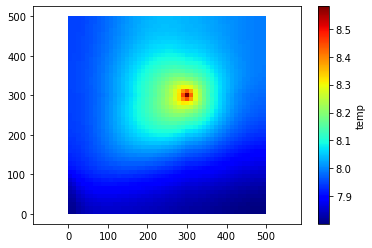

In [4]:
plt.figure()
coll=g.plot_cells(values=seg_3d[0,:],cmap='jet')
plt.colorbar(coll,label=param_name)
plt.axis('equal')

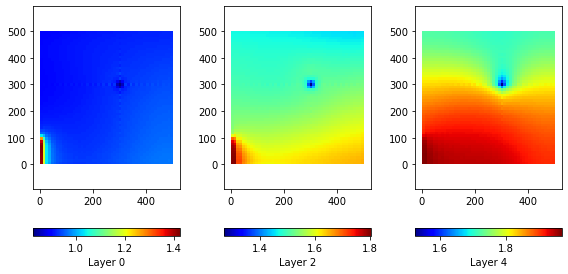

In [5]:
# If you have a segment file, but not a hyd file, you can still load
# it, but it's slightly more manual, you still need the corresponding
# grid file, and you need to know how many layers there are.
seg_fn="dfm_dwaq/dfm_run/DFM_DELWAQ_flowfm/flowfm.sal"
n_layers=5
grid=unstructured_grid.UnstructuredGrid.read_dfm('dfm_dwaq/dfm_run/grid_net.nc')
seg_func=dwaq.ParameterSpatioTemporal(seg_func_file=seg_fn,n_seg=n_layers*g.Ncells())
seg_func.load_from_segment_file()

seg_snapshot=seg_func.values[-1,:] # last timesteps, all segments
seg_3d=seg_snapshot.reshape( [-1,g.Ncells()])

fig,axs=plt.subplots(1,3,figsize=(8,4))
for ax,layer in zip(axs,[0,2,4]):
    coll=g.plot_cells(values=seg_3d[layer,:],cmap='jet',ax=ax)
    plt.colorbar(coll,label="Layer %d"%layer,ax=ax,orientation='horizontal')
    ax.axis('equal')
fig.tight_layout()

Merging DFM Output
==

In [12]:
import stompy.model.delft.dflow_model as dfm

mdu="/richmondvol1/rusty/wy2022_bloom/bloom_tracers_v15/run_20220801T0000_20220802T1930_v00/wy2022_bloom_16layer.mdu"
model = dfm.DFlowModel.load(mdu)
map_ds=model.map_dataset()


In [7]:
# how to get turkin1, ww1, others, do not merge.
# turkin1 has dimensions nFlowLink (vs nFlowElem) and wdim (vs laydim)
# map_ds.dss[0]

vars(map_ds).keys()


dict_keys(['paths', 'dss', 'grids', 'rev_meta', 'node_l2g', 'edge_l2g', 'cell_l2g', 'grid'])

In [10]:
map_ds['turkin1'] # DataArray, time, nFlowLink: 5642, wdim: 17
map_ds['s1'] # MultiVar
map_ds.rev_meta # No entry for nFlowLink, but it does have nFlowElem
# nFlowLink on domain 0: 5642.
# nFlowElem on domain 0: 3472
# nNetLink: 6354
# nNetElem: 3472
# So there is the extra issue that FlowLinks exclude closed boundaries, so it's a different
# mapping.



{'nNetNode': 'node_dimension',
 'nNetLink': 'edge_dimension',
 'nNetElem': 'face_dimension',
 'NetElemNode': 'face_node_connectivity',
 'NetLink': 'edge_node_connectivity',
 None: 'edge_coordinates',
 'NetNode_x NetNode_y': 'node_coordinates',
 'nFlowElem': 'face_dimension'}

In [11]:
map_ds.dss[0].dims

Frozen({'nmesh2d_EnclosurePoints': 689, 'nmesh2d_EnclosureInstance': 1, 'nmesh2d_EnclosureParts': 1, 'nNetNode': 2883, 'nNetLink': 6354, 'nNetLinkPts': 2, 'nNetElem': 3472, 'nNetElemMaxNode': 6, 'nNetLinkContourPts': 4, 'nBndLink': 713, 'nFlowElem': 3472, 'nFlowElemContourPts': 6, 'nFlowLink': 5642, 'nFlowLinkPts': 2, 'time': 45, 'laydim': 16, 'wdim': 17})